In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from statsmodels import robust

def plot_curve(bundled_data, title, curve, statistics, save_path=None):
    plt.figure(figsize=(6, 6))
    lw = 2

    handles = []
    for auc_mean, auc_sd, mean_curve_x, all_curve_y, wts, sample, color in bundled_data:
        if statistics == 'mean':
            mean_curve_y = np.mean(all_curve_y, axis=0)
            stds = np.sqrt(np.average((all_curve_y-mean_curve_y)**2, weights=wts, axis=0))
            q1 = mean_curve_y - stds
            q2 = mean_curve_y + stds
            label = "{0} ({1:0.2f} $\pm$ {2:0.2f})".format(sample, auc_mean, auc_sd)
        elif statistics == 'median':
            mean_curve_y = np.median(all_curve_y, axis=0)
            #stds = robust.mad(all_curve_y, axis=0)
            q1 = np.percentile(all_curve_y, 40, axis=0)
            q2 = np.percentile(all_curve_y, 60, axis=0)
            label = "{0} (median AUC = {1:0.2f})".format(sample, auc_mean)
        line, = plt.plot(mean_curve_x, mean_curve_y, color=color, alpha=0.6, 
                 lw=lw, label=label
                 )

        fill = plt.fill_between(
                    mean_curve_x, 
                    q1, 
                    q2,
                    color=color, 
                    alpha=0.2,  
                )
        
        handles.append(fill)
        handles.append(line)
        
    if curve == 'roc':
        plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    if curve == 'roc':
        plt.xlabel('False Positive Rate', fontsize=15)
        plt.ylabel('True Positive Rate', fontsize=15)
    elif curve == 'prc':
        plt.xlabel('Recall', fontsize=15)
        plt.ylabel('Precision', fontsize=15)

    # plt.title(title, fontsize=18)
    if statistics == 'mean':
        plt.legend(fontsize=10,
                title='AUC average $\pm$ standard error\nby fivefold cross-validation', 
                title_fontproperties={'size': 10, 'weight': 'bold'},
                loc="lower right",
                handles=[(handles[::-1][0], handles[::-1][1]), (handles[::-1][2], handles[::-1][3])],
                labels=[handles[::-1][0].get_label(), handles[::-1][2].get_label()])
    elif statistics == 'median':
        legend = plt.legend(
            fontsize=10,
            title='Median and quantile curves\nby fivefold cross-validation',
            title_fontproperties={'size': 10, 'weight': 'bold'},
            handles=[(handles[::-1][0], handles[::-1][1]), (handles[::-1][2], handles[::-1][3])],
            labels=[handles[::-1][0].get_label(), handles[::-1][2].get_label()],
            loc='lower right',
            # handler_map={tuple: HandlerTuple(ndivide=None)},
        )

    ax = plt.gca()  # get current axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    legend = ax.get_legend()
    legend.get_title().set_horizontalalignment('left')
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

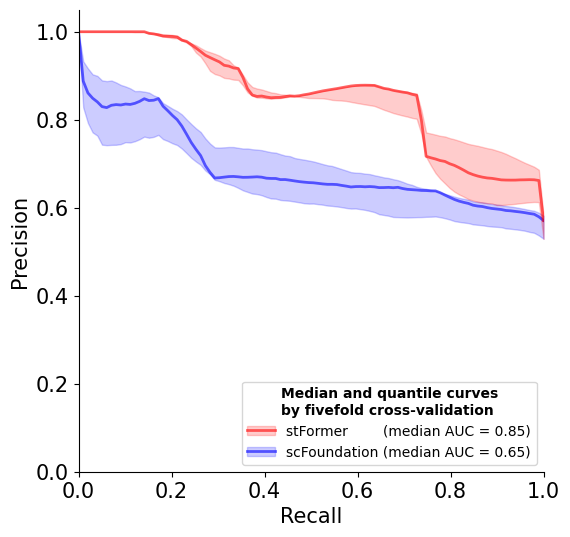

In [ ]:
bundled_data = []
color_list = ['blue', 'red']
legend_list = ['scFoundation', 'stFormer       ']

dataset = 'human_myocardial_infarction'
slide = 'ACH005_tgfb'
task = 'gcl'
curve = 'prc'
statistics = 'median'
save_path = f'{task}_{slide}_{curve}_{statistics}.pdf'
title = 'Gene set partition'

num = 0
for method in ['scf', 'stformer']:
    cv_results = pickle.load(open(f'{method}_{task}_{slide}_{curve}.pkl', 'rb'))
    if task == 'gcl':
        auc_mean, auc_sd, mean_curve_x, mean_curve_y, all_auc, wts, all_curve_y = cv_results.values()
        auc_median = np.median(all_auc)
        auc_mad = robust.mad(all_auc)
    if statistics == 'mean':
        bundled_data += [(auc_mean, auc_sd, mean_curve_x, all_curve_y, wts, legend_list[num], color_list[num])]
    elif statistics == 'median':
        bundled_data += [(auc_median, auc_mad, mean_curve_x, all_curve_y, wts, legend_list[num], color_list[num])]
    num += 1

plot_curve(bundled_data, title, curve, statistics, save_path)